In [14]:
import numpy as np
import pandas as pd
import datetime
import shap
import random
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error,roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.linear_model import Ridge

from category_encoders import TargetEncoder

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.svm import LinearSVR, SVR
#from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [15]:
seed = 42
VER = 7
n_folds = 5
n_bags = 3
TESTRUN = False

In [19]:
df_train=pd.read_csv("./train.csv", index_col=0)
df_original = pd.read_csv("./used_cars.csv")
df_test=pd.read_csv("./test.csv", index_col=0)
sample_sub=pd.read_csv("./sample_submission.csv")

#clean original columns
df_original[['milage', 'price']] = df_original[['milage', 'price']].map(
    lambda x: int(''.join(re.findall(r'\d+', x))))

#prepare dataframes for the oof and test predictions:
oof_df = pd.read_csv("./train.csv")[["id"]]
test_df = pd.read_csv("./test.csv")[["id"]]

In [18]:
if TESTRUN:
    df_train = df_train.sample(frac=0.2, random_state=seed)
    df_original = df_original.sample(frac=0.2, random_state=seed)
    oof_df = oof_df.sample(frac = 0.2, random_state = seed)

In [25]:
df_test.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
id,,,,,,,,,,,
188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 18.7+ MB


In [22]:
cat_cols = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 
            'int_col', 'accident']
num_cols = ['model_year', 'milage']

In [23]:
feature_cols = df_test.columns.to_list()
print("Number of duplicates in train data:", len(df_train[df_train[feature_cols].duplicated()]), "\n")
print("Number of duplicates in test data:", len(df_test[df_test.duplicated()]), "\n")

Number of duplicates in train data: 0 

Number of duplicates in test data: 0 



In [27]:
feat_stat = {}
for feature in df_train.columns:
    feat_stat[feature] = np.round(df_train[
        feature].value_counts().describe())[['count','mean', 'min', 'max']].astype(int)
feat_stat_df = pd.DataFrame(feat_stat)
feat_stat_df.T.sort_values(by=['count'])

,count,mean,min,max
clean_title,1,167114,167114,167114
accident,2,93040,41567,144514
fuel_type,7,26207,15,165940
model_year,34,5545,12,18198
transmission,52,3626,6,49904
brand,57,3308,3,23088
int_col,156,1209,4,107674
ext_col,319,591,2,48658
engine,1117,169,1,3462
price,1569,120,19,1920


In [28]:
print(df_train['price'].value_counts().sort_index().to_string())

price
2000         56
2300         73
2500        177
2800         40
2899         25
2900         38
2990         23
3000        191
3200         99
3499         44
3500        229
3550         42
3600         39
3750         32
3850        155
3900         80
3950         77
3990         37
3995         52
3999         52
4000        419
4100         43
4199         40
4200        252
4300        151
4399         41
4400         48
4495         44
4500        424
4700         99
4750         48
4800         97
4900        197
4995         49
4999        136
5000        524
5100         35
5199         42
5200         95
5230         35
5499         35
5500        577
5699         35
5700        124
5750         93
5800        204
5899         44
5900        240
5949         35
5990         46
5995        152
5999         43
6000        686
6099         39
6100         52
6250        165
6299         36
6300         48
6348         45
6399         51
6450         47
6499         98
65

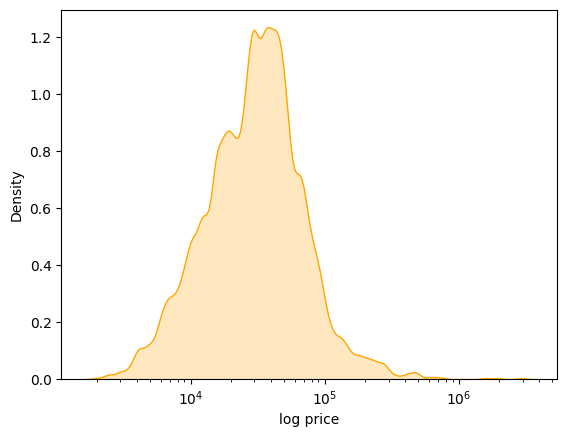

In [30]:
ax = sns.kdeplot(df_train['price'], color='orange', fill=True, log_scale=True)
ax.set(xlabel='log price');

In [31]:
def display_categories(df, feature, sort_feature='median price'):
    """
    displays the full list of categories of a categorical feature together with their
    properties count and mean and median price for each category
    """
    mean_price_per_category = np.round(df_train.groupby(feature)[
        'price'].mean()).reset_index().rename(columns={'price': 'mean price'})
    median_price_per_category = df_train.groupby(feature)[
        'price'].median().reset_index().rename(columns={'price': 'median price'})
    category_counts = pd.DataFrame(df_train[feature].value_counts())
    merger = pd.merge(mean_price_per_category, category_counts, on=feature)
    merger = pd.merge(median_price_per_category,merger, on = feature).sort_values(by=sort_feature)
    print(merger.to_string(index = False))
    return merger

In [32]:
for c in cat_cols + num_cols:
    # compare test and train cat values
    A=df_train[c].astype('str').unique()
    B=df_test[c].astype('str').unique()
    C = np.setdiff1d(B,A)
    print(f"{c}: Test has categories {C} which are not in train.")
    if len(C)>0:
        print(f" => {len(df_test.loc[df_test[c].astype(str).isin(C)])} rows" )
        
    # RELABEL UNSEEN TEST VALUES AS ZERO
    #test.loc[test[c].isin(C),c] = 0

brand: Test has categories [] which are not in train.
model: Test has categories ['allroad 2.7T'] which are not in train.
 => 1 rows
fuel_type: Test has categories [] which are not in train.
engine: Test has categories ['177.0HP 1.6L 4 Cylinder Engine Plug-In Electric/Gas'] which are not in train.
 => 4 rows
transmission: Test has categories [] which are not in train.
ext_col: Test has categories [] which are not in train.
int_col: Test has categories [] which are not in train.
accident: Test has categories [] which are not in train.
model_year: Test has categories ['1982' '1988'] which are not in train.
 => 2 rows
milage: Test has categories ['100633' '100678' '10073' ... '99876' '9988' '99981'] which are not in train.
 => 1981 rows


In [33]:
merger = display_categories(df_train, 'accident')

                              accident  median price  mean price  count
At least 1 accident or damage reported       18000.0     25334.0  41567
                         None reported       35000.0     49025.0 144514


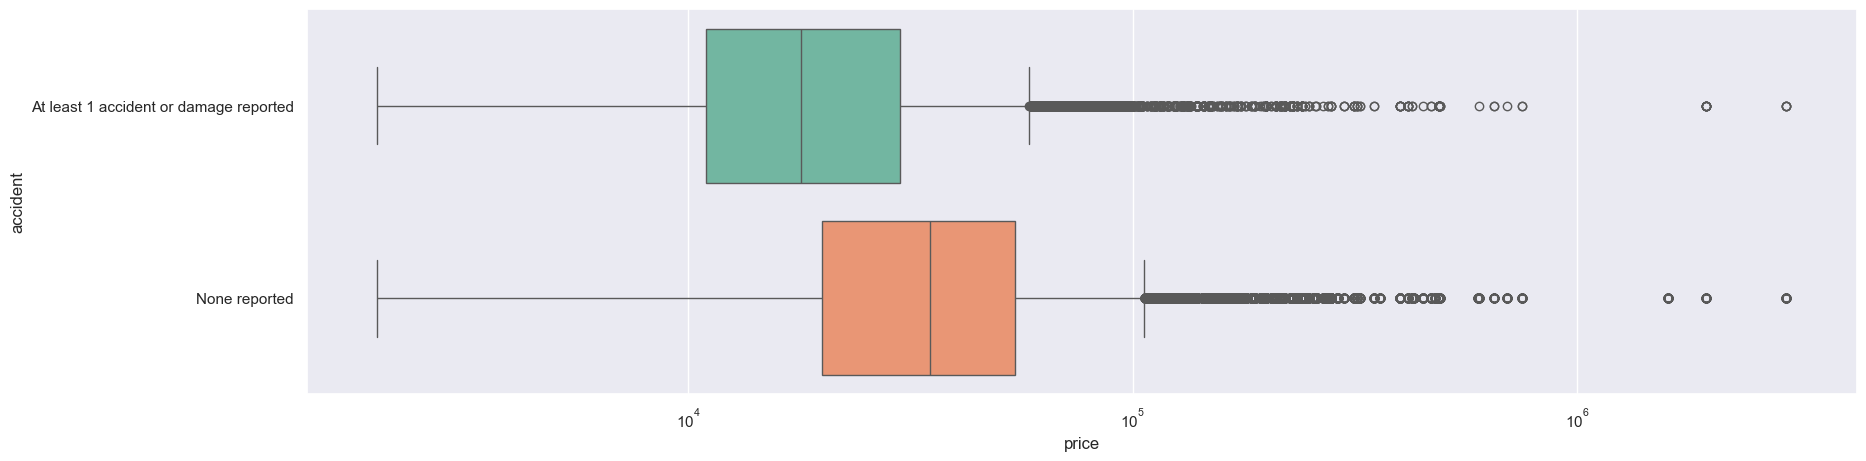

In [37]:
sns.set(rc={'figure.figsize': (20, 5)})
mean_price_order = df_train.groupby('accident')['price'].median().sort_values().index
sns.boxplot(y=df_train['accident'], x=df_train['price'], palette='Set2',
           order=mean_price_order) 
plt.xscale('log')

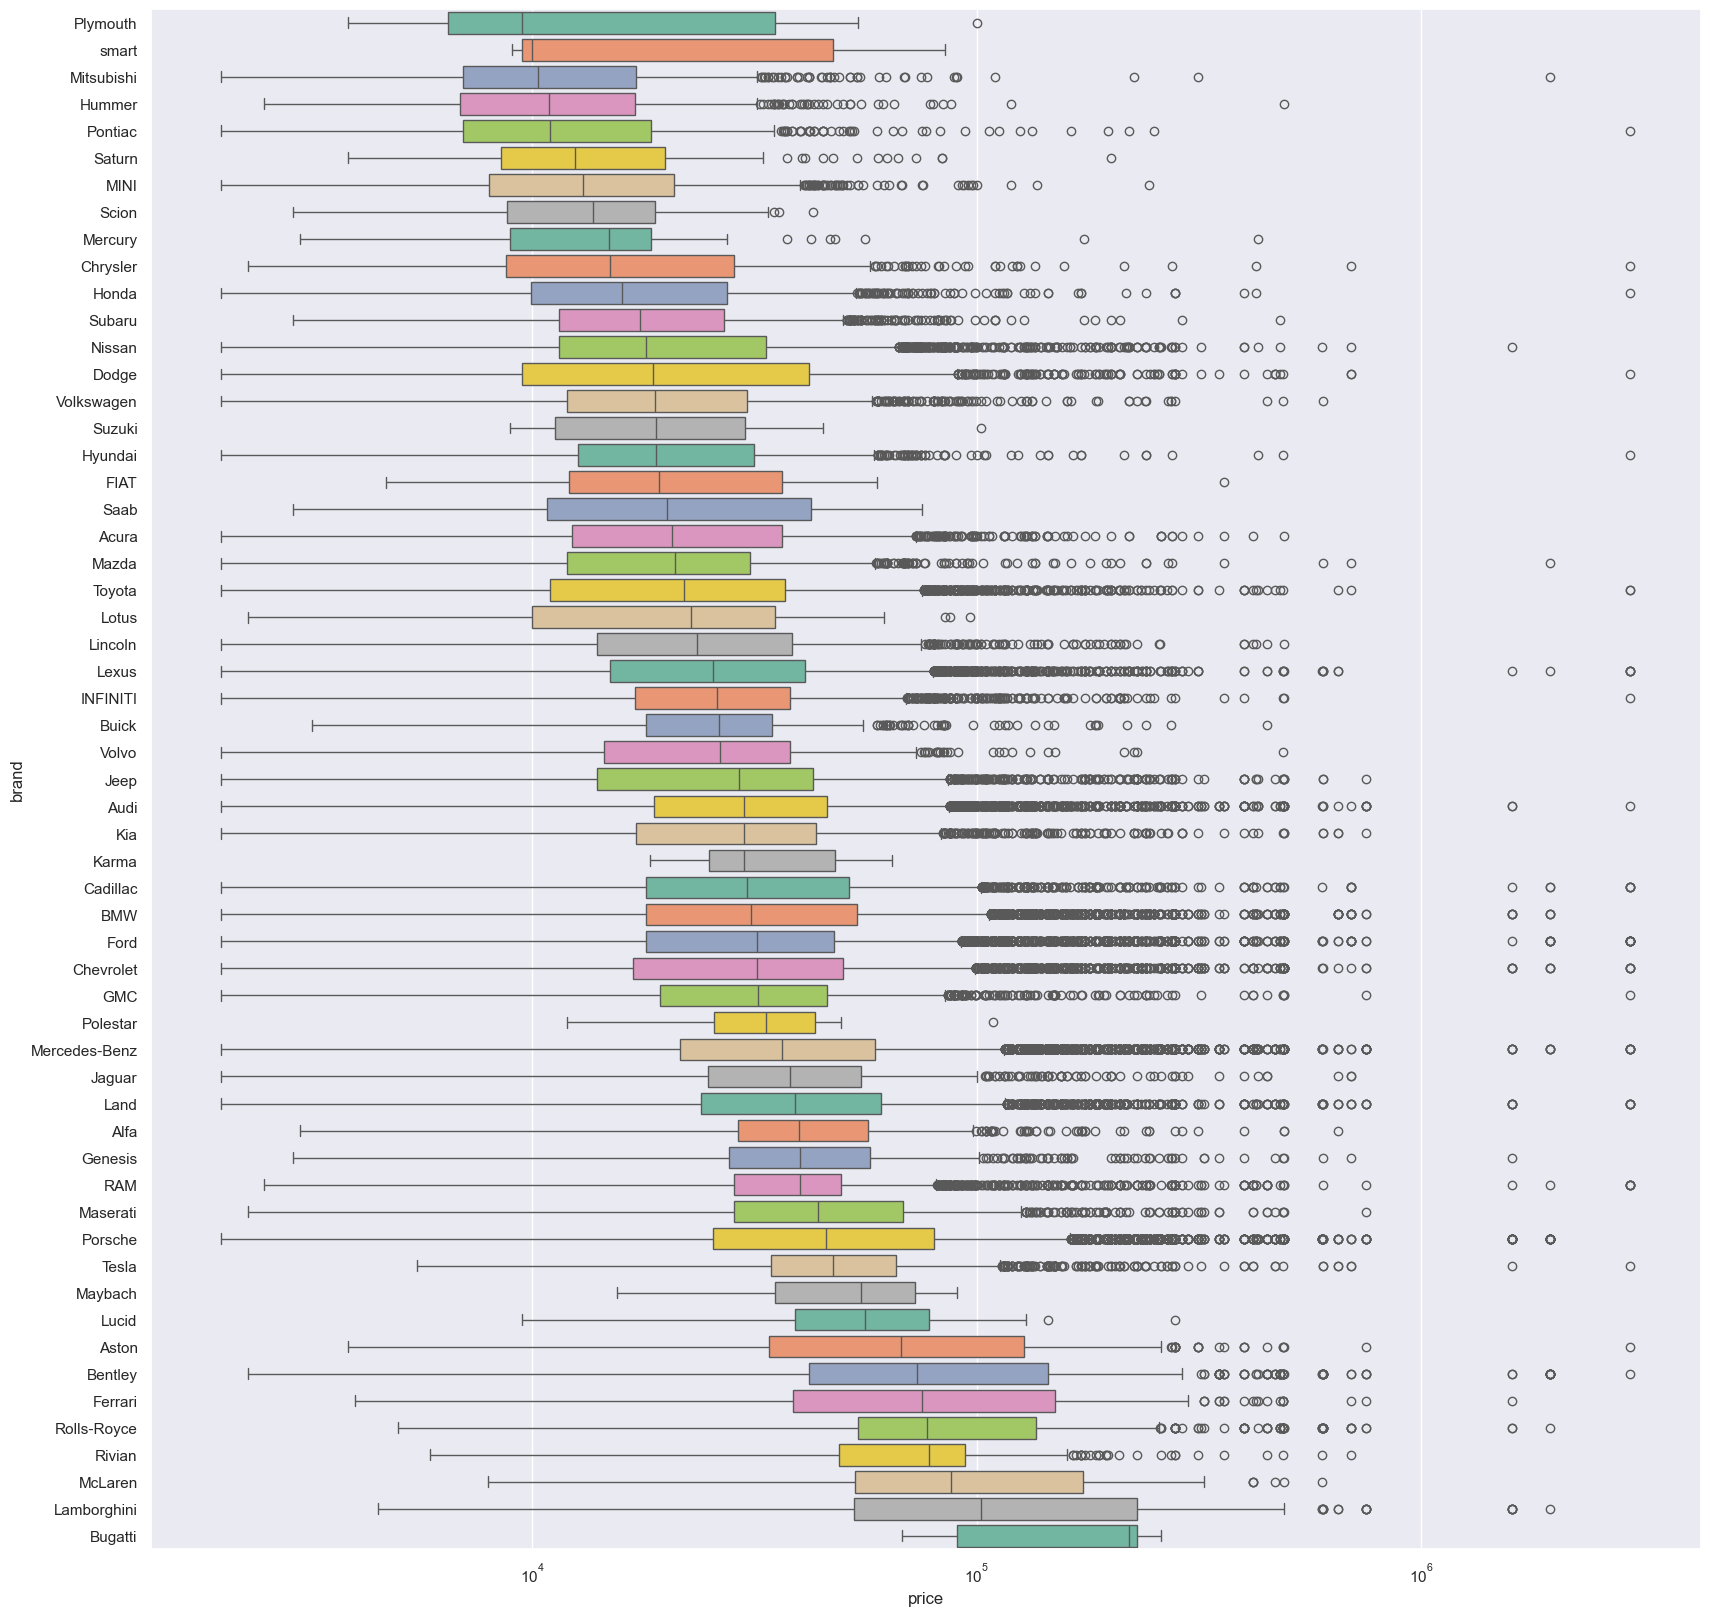

In [42]:
sns.set(rc={'figure.figsize': (20, 20)})
mean_price_order = df_train.groupby('brand')['price'].median().sort_values().index
ax = sns.boxplot(y=df_train['brand'], x=df_train['price'], palette='Set2',
           order=mean_price_order) 
plt.xscale('log')

In [49]:
merger = display_categories(df_train, 'model')

                                                  model  median price  mean price  count
                                                Yaris L        5750.0      8216.0      8
                                              Matrix XR        6375.0      7688.0     34
                                             Integra LS        6550.0      7683.0     34
                                                 325 xi        6825.0      9925.0     26
                                             Eurovan MV        6875.0      8246.0     42
                                  F-250 XL SuperCab H/D        7047.5     45027.0     16
                              Dakota Big Horn/Lone Star        7100.0      8801.0     40
                                         Cherokee Sport        7350.0     12893.0     22
                                           Ram Van 1500        7500.0      8694.0     22
                                           Dakota Sport        7500.0      9465.0     81
                     

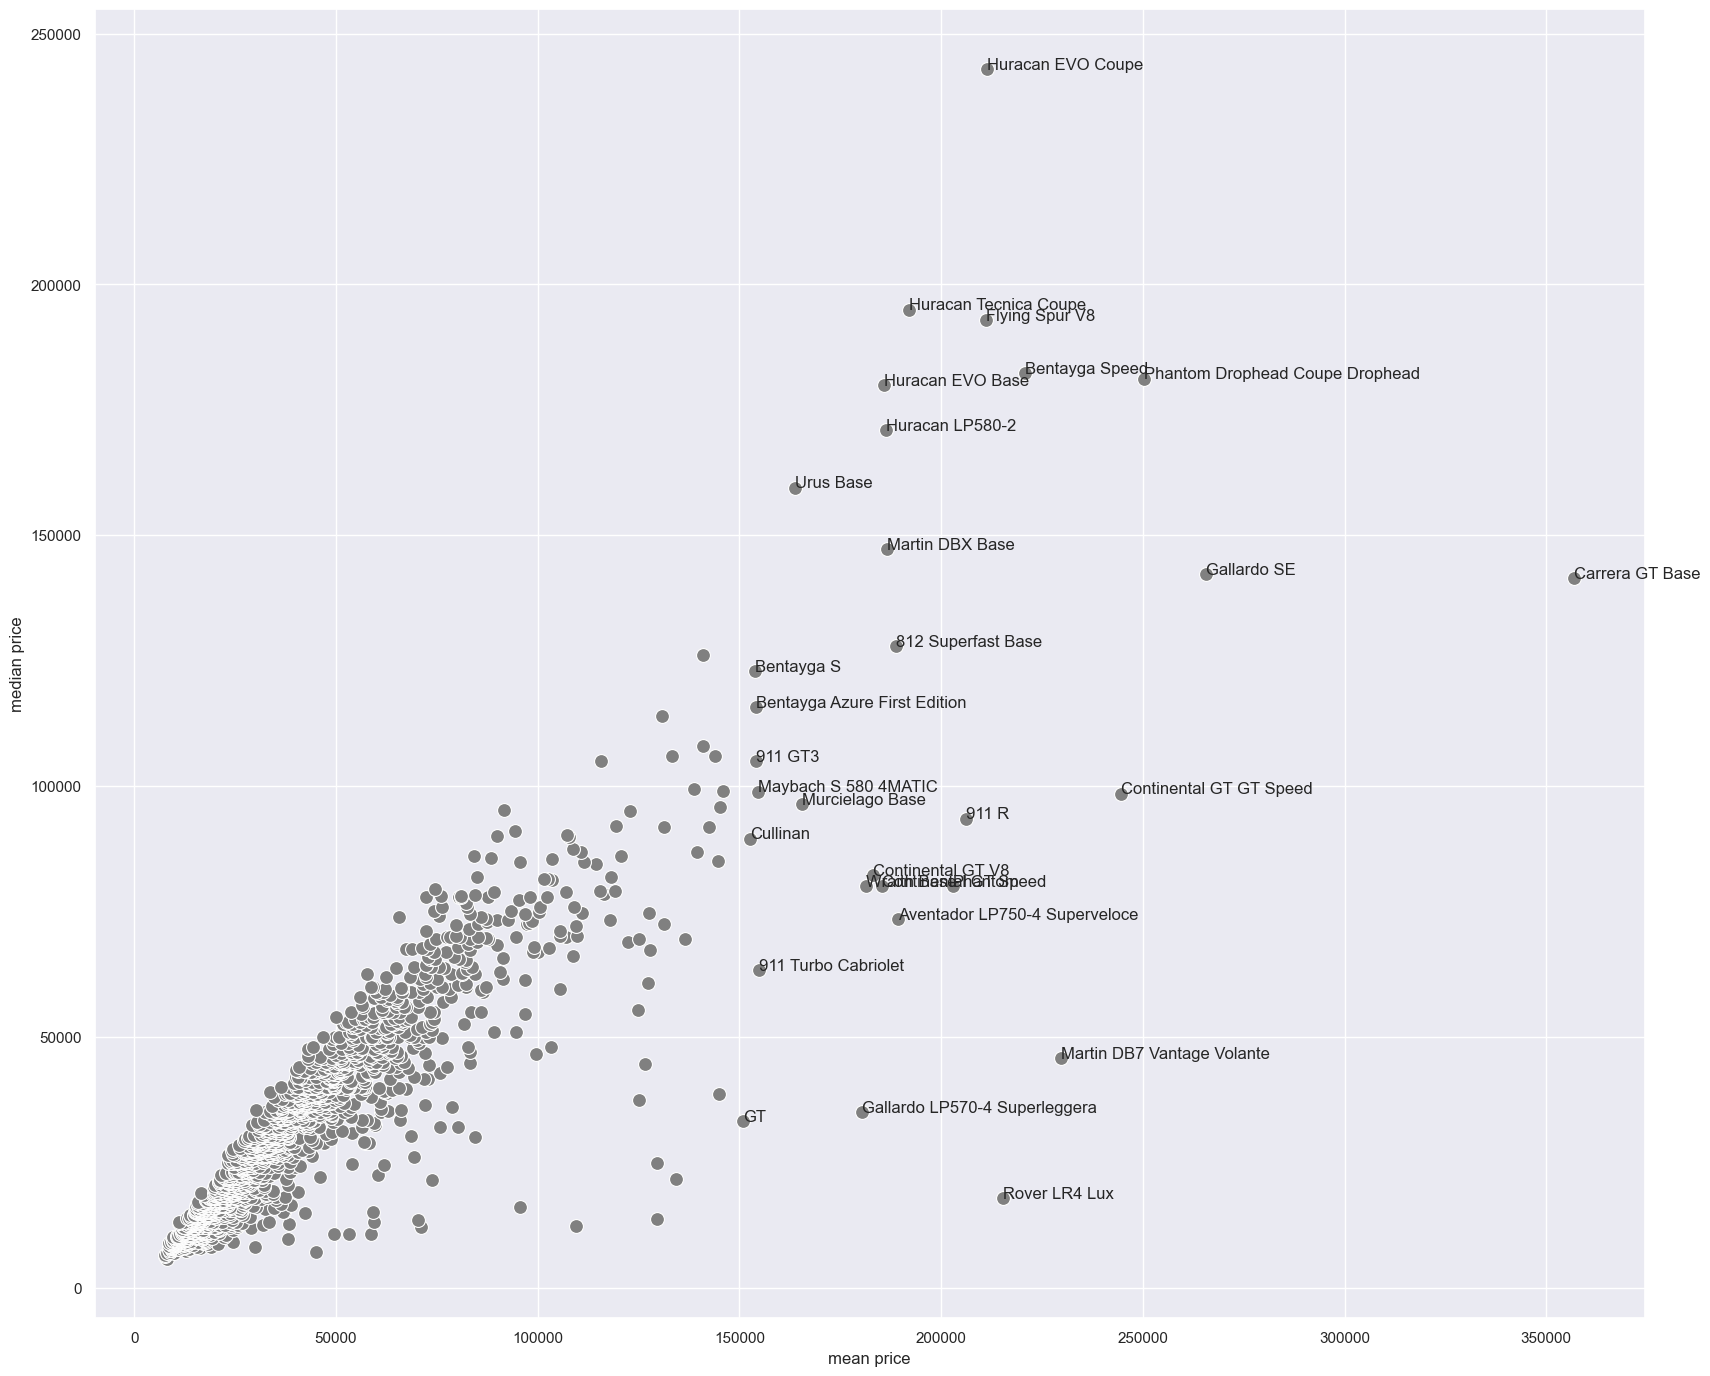

In [50]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if point['x'] > 150000:
            ax.text(point['x']+.02, point['y'], str(point['val']))

sns.set(rc={'figure.figsize': (20, 17)})
sns.scatterplot(x=merger['mean price'], y=merger['median price'],
                color='grey', s = 100)

label_point(merger['mean price'], merger['median price'], merger['model'], plt.gca()) 

plt.show()

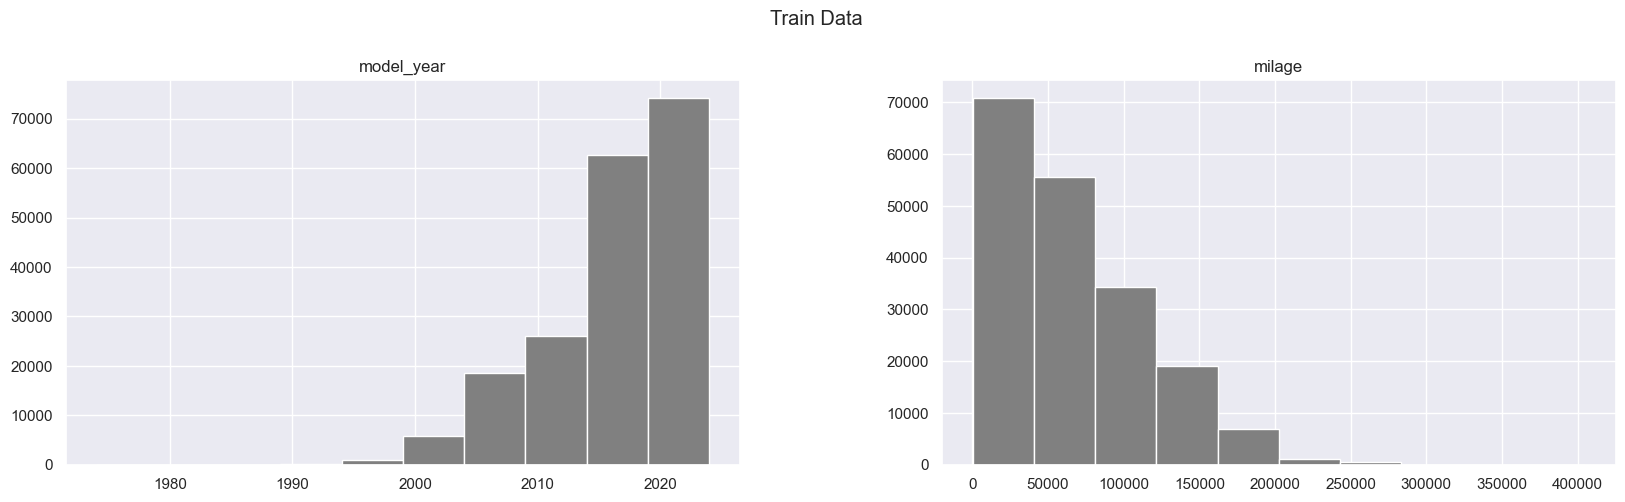

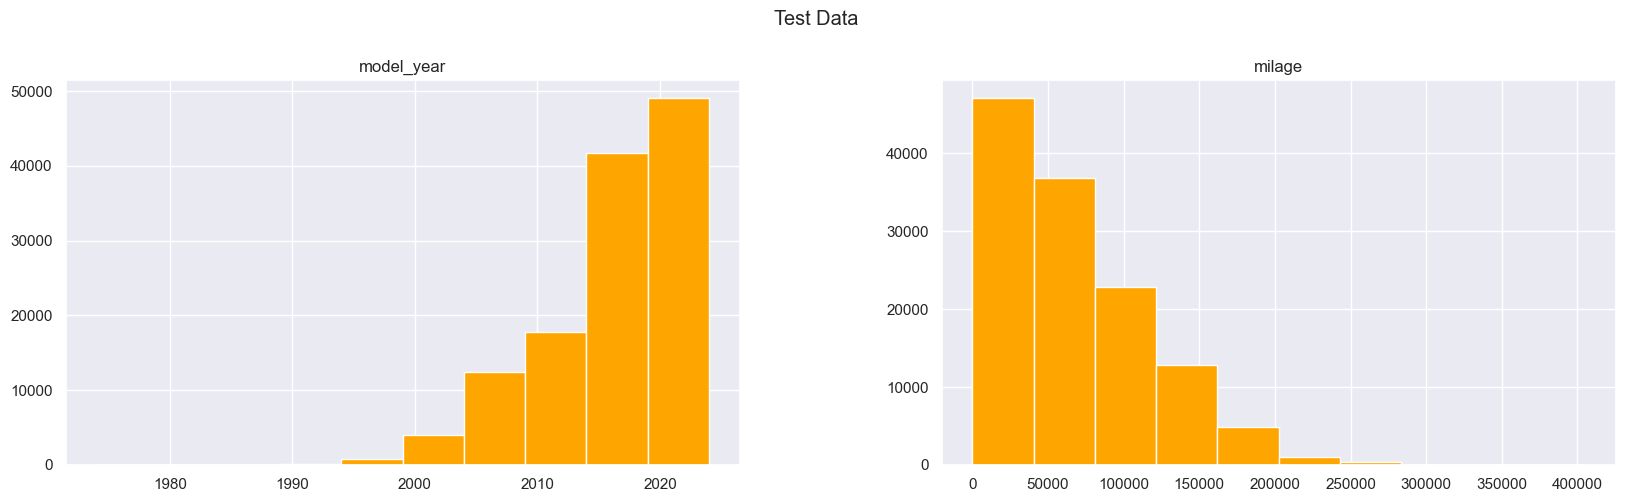

In [51]:
sns.set(rc={'figure.figsize': (20, 5)})
df_train[num_cols].hist(color = "grey")
plt.suptitle('Train Data', y=1.02)
df_test[num_cols].hist(color = "orange")
plt.suptitle('Test Data', y=1.02)
plt.show()

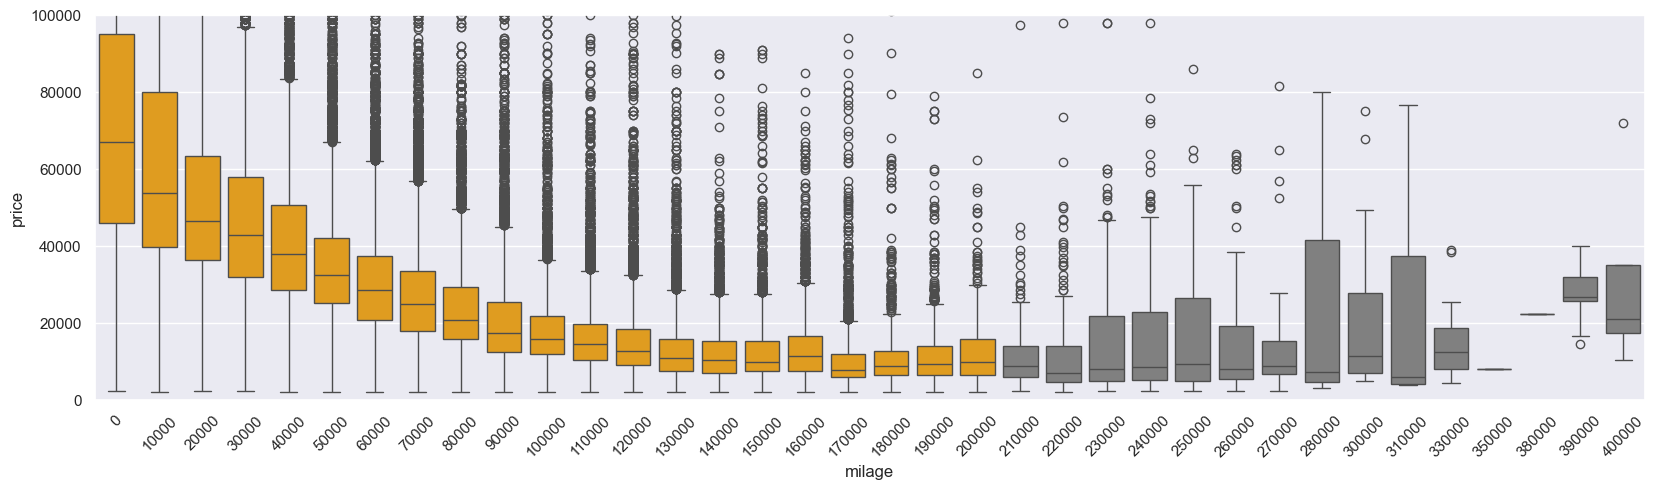

In [52]:
def set_boxplot_color(x):
    colors = []
    for bin in x.value_counts().index:
        count = x.value_counts()[bin]
        color = 'orange' if count > 500 else 'grey'
        colors.append(color)
    return colors

sns.set(rc={'figure.figsize': (20, 5)})
milage2 = (df_train.milage//10_000)*10_000
colors = set_boxplot_color(milage2)
sns.boxplot(x=milage2, y=df_train['price'], palette = colors)
plt.ylim((0,100_000))
plt.xticks(rotation=45)
plt.show()

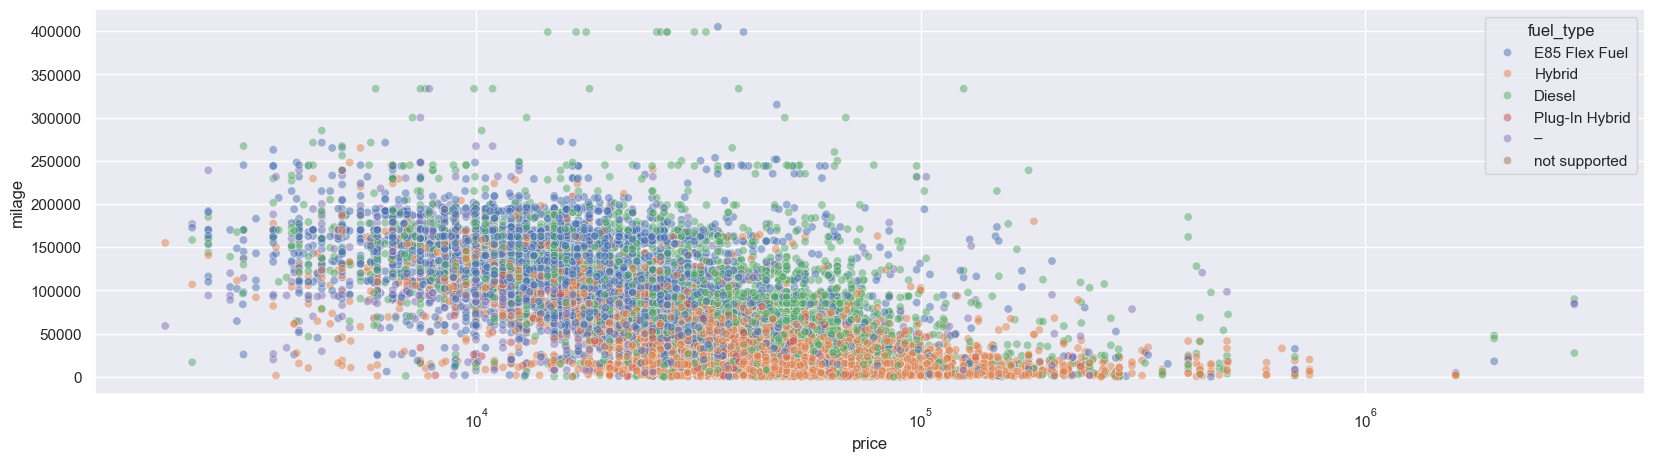

In [53]:
sns.scatterplot(x=df_train[df_train['fuel_type'] != 'Gasoline']['price'], 
                y=df_train[df_train['fuel_type'] != 'Gasoline']['milage'],
                hue = df_train[df_train['fuel_type'] != 'Gasoline']['fuel_type'],
                color='grey', alpha=0.5)
plt.xscale('log')

In [56]:
display_categories(df_train, 'engine')

                                                               engine  median price  mean price  count
                275.0HP 4.2L Straight 6 Cylinder Engine Gasoline Fuel        6099.5      7653.0     12
                        253.0HP 3.5L V6 Cylinder Engine Gasoline Fuel        6450.0     25677.0      5
                        140.0HP 2.8L V6 Cylinder Engine Gasoline Fuel        6500.0      7805.0     43
                         130.0HP 1.8L 4 Cylinder Engine Gasoline Fuel        6500.0      8394.0     59
                         255.0HP 4.8L 8 Cylinder Engine Gasoline Fuel        6700.0     12462.0     16
                        170.0HP 3.3L V6 Cylinder Engine Gasoline Fuel        6900.0      9398.0     17
                         300.0HP 6.0L 8 Cylinder Engine Gasoline Fuel        6950.0      8259.0     27
                         182.0HP 4.0L 8 Cylinder Engine Gasoline Fuel        6999.5      8223.0     34
                         245.0HP 5.9L 8 Cylinder Engine Gasoline Fuel    

,engine,median price,mean price,count
438,275.0HP 4.2L Straight 6 Cylinder Engine Gasoli...,6099.5,7653.0,12
367,253.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6450.0,25677.0,5
55,140.0HP 2.8L V6 Cylinder Engine Gasoline Fuel,6500.0,7805.0,43
36,130.0HP 1.8L 4 Cylinder Engine Gasoline Fuel,6500.0,8394.0,59
374,255.0HP 4.8L 8 Cylinder Engine Gasoline Fuel,6700.0,12462.0,16
...,...,...,...,...
798,4.0L H6 24V GDI DOHC,154900.0,221397.0,277
1039,6.0L W12 48V PDI DOHC Twin Turbo,162950.0,210264.0,137
948,5.2L V10 40V GDI DOHC,186925.0,197062.0,190
28,12 Cylinder Engine,213970.5,204101.0,8


In [57]:
def feat_eng(data):
    #categorical features
    cat_cols = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 
                'int_col', 'accident']
    df = data.copy()
    
    for feature in ['fuel_type', 'accident', 'clean_title']:
        df[feature] = df[feature].fillna("no_entry")
    df['clean_title'] = np.where(df['clean_title']== 'Yes',1,0).astype('int16')
    df['fuel_type'] = df['fuel_type'].replace({'–':'not supported'})
    df['mileage'] = df['milage']//100
    
    for feature in cat_cols:
        df[feature] = df[feature].astype('category')
    #numerical features
    df['horsepower'] = df['engine'].str.extract(r'(\d+\.?\d*)HP').astype('float').fillna(-1)
    df['displacement'] = df['engine'].str.extract(r'(\d+(\.\d+)?)L')[0].astype(float).fillna(-1)
    return df

In [58]:
feat_cols = df_test.columns.to_list()
data_concat = feat_eng(pd.concat([df_train[feat_cols], df_original[feat_cols], df_test]))
data_train = data_concat[:len(df_train)]
data_train['price']=df_train['price']
data_original = data_concat[len(df_train):len(df_train)+len(df_original)]
data_original['price'] = df_original['price']
data_test = data_concat[len(df_train)+len(df_original):]
cat_cols = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 
                'int_col', 'accident', 'model_year','mileage', 
           ]
num_cols = ['milage', 'horsepower', 'displacement']